In [17]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# First pass

At a high level, a VAE is just an Autoencoder with some extra stuff to make the latent space better.

An autoencoder $f(x)$ simply takes an input $x$ and produces a reconstruction of $x$ as $\hat{x}$. It distills $x$ into less numbers as a compression (bottleneck) as $$f(x) = \text{decode}(\text{encode}(x))$$ where encode and decode are both learnable functions.

With VAEs, the encode function produces a probability distribution rather than numbers that the decoder uses directly. At the encoding step, we use the probability distribution to randomly sample the vector, which then gets decoded by the decoder. 

In [32]:
# Example of untrained vanilla autoencoder
# with an input of 10 numbers and tries to reconstruct 10 numbers (not very well since not trained)
with torch.no_grad():
	torch.manual_seed(0)
	encoder = torch.nn.Sequential(
		nn.Linear(10, 5),
		nn.ReLU(),
		nn.Linear(5, 2),
	)
	decoder = nn.Sequential(
		nn.Linear(2, 5),
		nn.ReLU(),
		nn.Linear(5, 10),
	)
	x = torch.randn((1, 10))
	f = lambda x: decoder(encoder(x))
	x_hat = f(x)
	print("x", x)
	print("x_hat", x_hat)
	print("reconstruction loss", F.mse_loss(x_hat, x))

x tensor([[ 0.3014, -0.9764, -0.0254, -0.1521, -0.0268,  0.6461,  0.6105,  0.9971,
          0.4083,  0.5957]])
x_hat tensor([[-0.3292,  0.0935,  0.4351,  0.1092, -0.1609,  0.0980,  0.0332,  0.2981,
          0.3660,  0.3332]])
reconstruction loss tensor(0.3033)


## Second Pass

Why does turning the bottleneck into a probability distribution help? And how can we represent that in math and pytorch?

The logic is that Autoencoders can embed their vectors anywhere in space. So the output shape might be terrible for us humans to reason about. Additionally, vector math and interpolation between vectors in the latent space, might not be as smooth as we'd want. 

We humans deal with lines, whereas the autoencoder can embed a very non-linear latent space that is understandable to the autoencoder, but not to us.

> [!NOTE]
> You could in theory run a secondary Sparse Autoencoder (SAE) to interpolate a vanilla autoencoders latent space if it's not great to look at. This is redundant. Let's just use a VAE.

In essence, instead of outputting a vector that is directly decoded as $$\vec{v} = \begin{bmatrix}v_0\\v_1\\\vdots\\v_n\end{bmatrix}$$ where $n$ is the size of the latent space $\mathbb{R}^n$, we instead can represent the output as the parameters in a probability distribution and take $\vec{v}$ as a sample from the constructed distribution.

For example, we could output two vectors in the latent space as
$$
\begin{align}
	\vec{\mu} &= \begin{bmatrix}\mu_0\\\mu_1\\\vdots\\\mu_i\end{bmatrix}\\
	\vec{\sigma} &= \begin{bmatrix}\sigma_0\\\sigma_1\\\vdots\\\sigma_i\end{bmatrix}
\end{align}
$$

where each pair of matching indices from $\vec{\mu}$ and $\vec{\sigma}$ are then sampled from a Gaussian distribution to recreate the $\vec{v}$ as
$$
\begin{align}
	\vec{v} &= \begin{bmatrix}
					v_0 \sim N(\mu_0, \sigma_0^2)\\
					v_1 \sim N(\mu_1, \sigma_1^2)\\
					\vdots\\
					v_n \sim N(\mu_n, \sigma_n^2)\\
				\end{bmatrix}\\
\end{align}
$$ 

using a random sampler during inference time. This way, each value in $\vec{v}$ is a continuous function with a value realized at inference time. The latent space created from these outputs looks much more normally distributed (duh) and nicer to work with and do vector math on. Making the VAE more useful in more cases than the regular AE.

Note that the standard deviations need to be positive so we can apply an activation like ReLU or softplus to the standard deviation functions in the latent space before sampling.

Note that since we sample to create the vector, we have to create a pathway for the gradient that doesn't terminate. How does one backprop through a random number generator? The workaround is called the reparameterization trick.

This is where use the fact that a normal distribution can be represented as the standard deviation times a standard normal distribution + the mean. So we have that $$\vec{v} = \mu + \sigma \epsilon$$ where $\epsilon \sim N(0, 1)$.

In [42]:
# now let me change the example before to include the normal distributions 
class SmallVAE(nn.Module):
	def __init__(self):
		super().__init__()
		# encoder
		self.enc_fc1 = nn.Linear(10, 5)
		# prob dist (replaces the latent embedder)
		self.enc_mu = nn.Linear(5, 2)
		self.enc_sig = nn.Linear(5, 2)

		# decoder
		self.dec_fc1 = nn.Linear(2, 5)
		self.dec_fc2 = nn.Linear(5, 10)
		
	def forward(self, x):
		# encoder
		x = self.enc_fc1(x)
		x = F.relu(x)
		sig, mu = self.enc_sig(x), self.enc_mu(x)
		sig = F.softplus(sig) # standard deviation must be positive, mean can be anything

		eps = torch.randn_like(sig) # standard normal
		x = mu + sig*eps # reconstruct the vector from sample

		# decoder
		x = self.dec_fc1(x)
		x = F.relu(x)
		x = self.dec_fc2(x)

		return x

with torch.no_grad():
	torch.manual_seed(0)
	f_vae = SmallVAE()
	x = torch.randn((1, 10))
	x_hat = f_vae(x)

	print(f_vae)
	print("x", x)
	print("x_hat", x_hat)



SmallVAE(
  (enc_fc1): Linear(in_features=10, out_features=5, bias=True)
  (enc_mu): Linear(in_features=5, out_features=2, bias=True)
  (enc_sig): Linear(in_features=5, out_features=2, bias=True)
  (dec_fc1): Linear(in_features=2, out_features=5, bias=True)
  (dec_fc2): Linear(in_features=5, out_features=10, bias=True)
)
x tensor([[ 0.6105,  0.9971,  0.4083,  0.5957, -0.8193,  0.5156,  0.4135,  0.9219,
         -1.3676, -0.1525]])
x_hat tensor([[-0.3887,  0.0052, -0.3608,  0.5877, -0.3170, -0.2160, -0.8451, -0.4282,
         -0.0110,  0.8447]])


## Third Pass

Actually, keeping the sigma values positive with softplus or ReLU is a bit of a hack. We can simply change the space of values we're working with and undo this function to reclaim the sigma's whenever we want. This is known as the logvar trick.

If we simply assume that the values we get from the latent layer is $l = \ln(\sigma^2)$, then if we expo and divide by 2 we get  $e^{l/2} = \sigma$ which essentially allows $l$ to be positive or negative, and we simply retrieve the $\sigma$ when we need it. Note that since we'll need the $\ln(\sigma^2)$ in the loss function we can also directly use this value during training.

How does this trick differ to just considering $l$ as $\sigma$ and applying a positive activation function (ReLU or Softplus)? Look below. The function are remarkably similar. So it likely doesn't even matter that much.

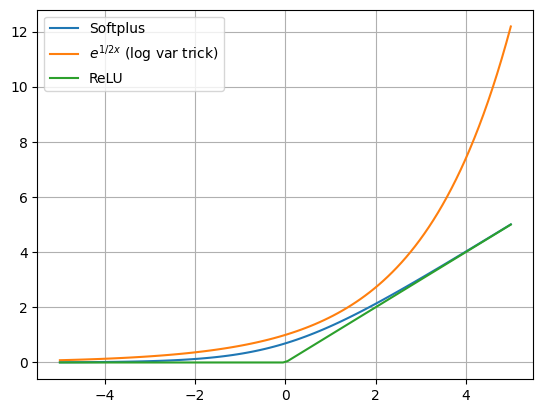

In [56]:
xs = torch.linspace(-5, 5, 100)
sp = F.softplus(xs)
log_var = torch.exp(0.5*xs)
relu = torch.relu(xs)
plt.plot(xs, sp, label="Softplus")
plt.plot(xs, log_var, label="$e^{1/2 x}$ (log var trick)")
plt.plot(xs, relu, label="ReLU")
plt.grid()
plt.legend()
plt.show()

## References

- https://www.ibm.com/think/topics/variational-autoencoder#:~:text=Variational%20autoencoders%20(VAEs)%20are%20generative,other%20autoencoders%2C%20such%20as%20denoising. (good overview)
- https://www.youtube.com/watch?v=9zKuYvjFFS8 (softplus on standard deviation encoding)
- https://arxiv.org/abs/1312.6114 (original VAE paper)
- https://www.youtube.com/watch?v=afNuE5z2CQ8 (log var trick)